In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score

## Part 3

In [2]:
class KMeansScratch:
    def __init__(self, k, max_iters=100, tolerance=1e-4, n_init=5):
        self.k = k
        self.max_iters = max_iters
        self.tolerance = tolerance
        self.n_init = n_init
        self.centroids = None
        self.labels_ = None
        self.inertia_ = None

    def fit(self, data):
        n_samples, n_features = data.shape
        best_inertia = float('inf')
        best_labels = None
        best_centroids = None

        for _ in range(self.n_init): 
            self.centroids = data[np.random.choice(n_samples, self.k, replace=False)]

            for i in range(self.max_iters):
                # Assign clusters based on closest centroid
                clusters = self._create_clusters(data)
                
                # Calculate new centroids
                new_centroids = np.array([data[clusters == j].mean(axis=0) for j in range(self.k)])
            
                # Check for convergence
                if np.all(np.abs(new_centroids - self.centroids) < self.tolerance):
                    break
                self.centroids = new_centroids

            # Update labels_ and inertia_ after each iteration
            self.labels_ = self._create_clusters(data)  
            self.inertia_ = self.inertia(data)  # Calculate and store inertia

            if self.inertia_ < best_inertia:
                best_inertia = self.inertia_
                best_labels = self.labels_
                best_centroids = self.centroids

        # Assign the best found labels, centroids, and inertia at the end of the loop
        self.labels_ = best_labels
        self.centroids = best_centroids 
        self.inertia_ = best_inertia

    def _create_clusters(self, data):
        return np.array([self._closest_centroid(data_point) for data_point in data])

    def _closest_centroid(self, data_point):
        distances = [np.linalg.norm(data_point - centroid) for centroid in self.centroids]
        return np.argmin(distances)

    def predict(self, data):
        return np.array([self._closest_centroid(data_point) for data_point in data])

    def inertia(self, data):
        return np.sum([np.linalg.norm(data_point - self.centroids[cluster]) ** 2 for data_point, cluster in zip(data, self.labels_)])

In [3]:
silhouette_scores = {}

#### dataset: `Compact.csv`

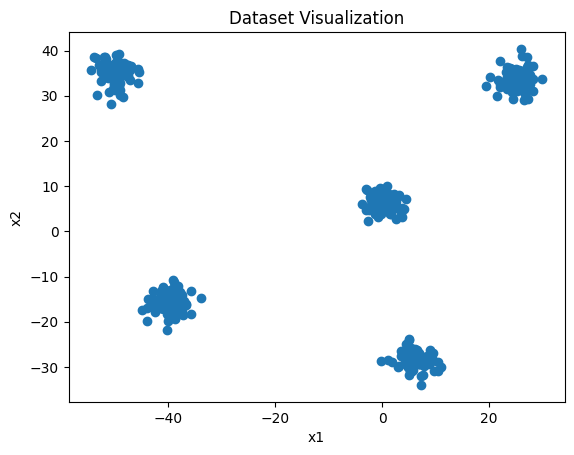

In [ ]:
data = pd.read_csv('./Dataset_a5/Dataset2/Compact.csv')

X = data[["x1", "x2"]].values

plt.scatter(X[:, 0], X[:, 1])
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Dataset Visualization")
plt.show()


In [8]:
kmeans = KMeansScratch(k=5)

kmeans.fit(X)
labels_kmeans = kmeans.labels_

# print(f"Silhouette Score for KMeans: {silhouette_score(X, labels_kmeans)}")

In [9]:
linkages = ['ward', 'complete', 'average', 'single']

best_silhouette = -1
best_linkage = None

for linkage in linkages:
    agg_clustering = AgglomerativeClustering(n_clusters=3, linkage=linkage)
    agg_clustering.fit(X)
    labels_agg_tmp = agg_clustering.labels_

    silhouette_tmp = silhouette_score(X, labels_agg_tmp)

    if silhouette_tmp > best_silhouette:
        best_silhouette = silhouette_tmp
        best_linkage = linkage

print(f"Best linkage: {best_linkage}")
# print(f"Best silhouette score: {best_silhouette}")

agg_clustering = AgglomerativeClustering(n_clusters=5, linkage=best_linkage)
agg_clustering.fit(X)
labels_agg = agg_clustering.labels_

Best linkage: single


In [10]:
# eps_values = [1, 2, 3, 4, 5]
# min_samples_values = [1, 10, 20, 30, 40, 50]

# best_silhouette = -1
# best_eps = None
# best_min_samples = None
# labels_dbscan = None
# noise_points = None

# for eps in eps_values:
#     for min_samples in min_samples_values:
#         dbscan = DBSCAN(eps=eps, min_samples=min_samples)
#         dbscan.fit(X)
#         labels_dbscan_tmp = dbscan.labels_

#         # Ignore noise points for silhouette score
#         non_noise_indices = labels_dbscan_tmp != -1
#         if len(set(labels_dbscan_tmp[non_noise_indices])) > 1:
#             silhouette_tmp = silhouette_score(X[non_noise_indices], labels_dbscan_tmp[non_noise_indices])
#         else:
#             silhouette_tmp = -1  # Assign a low silhouette score if only one cluster is found

#         if silhouette_tmp > best_silhouette:
#             best_silhouette = silhouette_tmp
#             best_eps = eps
#             best_min_samples = min_samples
#             labels_dbscan = labels_dbscan_tmp
#             noise_points = np.sum(labels_dbscan == -1)

dbscan = DBSCAN(eps=3, min_samples=3)
dbscan.fit(X)
labels_dbscan = dbscan.labels_
noise_points = np.sum(labels_dbscan == -1)

non_noise_indices = labels_dbscan != -1

# print(f"Best eps: {best_eps}")
# print(f"Best min_samples: {best_min_samples}")
# print(f"Best silhouette score: {best_silhouette}")

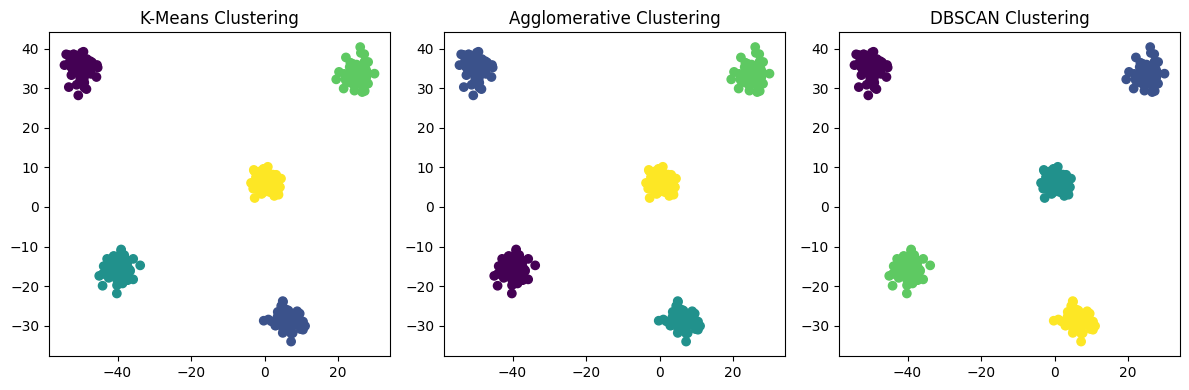

In [11]:
plt.figure(figsize=(12, 4))

# K-Means
plt.subplot(1, 3, 1)
plt.scatter(X[:, 0], X[:, 1], c=labels_kmeans)
plt.title("K-Means Clustering")

# Agglomerative Clustering
plt.subplot(1, 3, 2)
plt.scatter(X[:, 0], X[:, 1], c=labels_agg)
plt.title("Agglomerative Clustering")

# DBSCAN
plt.subplot(1, 3, 3)
plt.scatter(X[:, 0], X[:, 1], c=labels_dbscan)
plt.title("DBSCAN Clustering")

plt.tight_layout()
plt.show()

In [12]:
# Silhouette scores
silhouette_kmeans = silhouette_score(X, labels_kmeans)
silhouette_agg = silhouette_score(X, labels_agg)
silhouette_dbscan = silhouette_score(X[non_noise_indices], labels_dbscan[non_noise_indices])

silhouette_scores["compact"] = {
    "K-Means": silhouette_kmeans,
    "Agglomerative Clustering": silhouette_agg,
    "DBSCAN": silhouette_dbscan
}

# Intra-cluster distance (sum of squared distances to centroids)
kmeans_intra_distance = kmeans.inertia(X)
agg_intra_distance = np.sum([np.linalg.norm(X[labels_agg == i] - np.mean(X[labels_agg == i], axis=0)) ** 2 for i in range(3)])
dbscan_intra_distance = np.sum([np.linalg.norm(X[labels_dbscan == i] - np.mean(X[labels_dbscan == i], axis=0)) ** 2 for i in range(np.max(labels_dbscan) + 1)])

# Tabulate results
results = pd.DataFrame({
    "Algorithm": ["K-Means", "Agglomerative Clustering", "DBSCAN"],
    "Silhouette Score": [silhouette_kmeans, silhouette_agg, silhouette_dbscan],
    "Intra-Cluster Distance": [kmeans_intra_distance, agg_intra_distance, dbscan_intra_distance],
    "Noise Points": [0, 0, noise_points]
})

results

,Algorithm,Silhouette Score,Intra-Cluster Distance,Noise Points
0,K-Means,0.91178,3163.693808,0
1,Agglomerative Clustering,0.91178,1987.446642,0
2,DBSCAN,0.91178,3163.693808,0


Analysis:

It appears that Agglomerative clustering is the best method for this dataset. While the silhouette score is same for all the methods and even visually, all the methods seem to have done a good job, if we look at inter-cluster distance, we can see that Agglomerative clustering has the least inter-cluster distance. This means that the clusters are more compact and well separated. This is the reason why Agglomerative clustering is the best method for this dataset. 

#### dataset: `Skewed.csv`

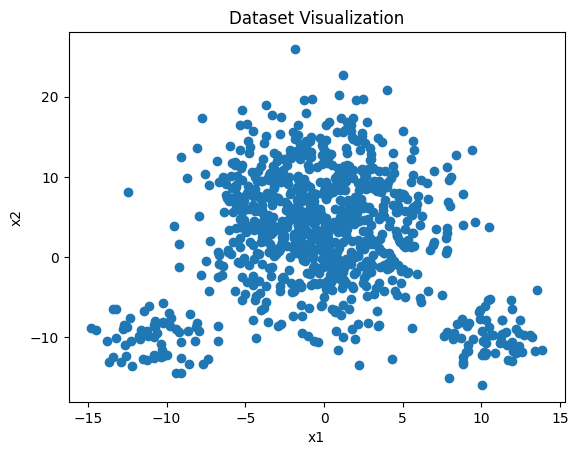

In [13]:
data = pd.read_csv('./Dataset_a5/Dataset2/Skewed.csv')

X = data[["x1", "x2"]].values

plt.scatter(X[:, 0], X[:, 1])
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Dataset Visualization")
plt.show()


In [14]:
kmeans = KMeansScratch(k=3)

kmeans.fit(X)
labels_kmeans = kmeans.labels_

In [15]:
linkages = ['ward', 'complete', 'average', 'single']

best_silhouette = -1
best_linkage = None

for linkage in linkages:
    agg_clustering = AgglomerativeClustering(n_clusters=3, linkage=linkage)
    agg_clustering.fit(X)
    labels_agg_tmp = agg_clustering.labels_

    silhouette_tmp = silhouette_score(X, labels_agg_tmp)

    if silhouette_tmp > best_silhouette:
        best_silhouette = silhouette_tmp
        best_linkage = linkage

print(f"Best linkage: {best_linkage}")
# print(f"Best silhouette score: {best_silhouette}")

agg_clustering = AgglomerativeClustering(n_clusters=5, linkage=best_linkage)
agg_clustering.fit(X)
labels_agg = agg_clustering.labels_

Best linkage: average


In [16]:
# eps_values = [1, 2, 3, 4, 5]
# min_samples_values = [1, 10, 20, 30, 40, 50]

# best_silhouette = -1
# best_eps = None
# best_min_samples = None
# labels_dbscan = None
# noise_points = None

# for eps in eps_values:
#     for min_samples in min_samples_values:
#         dbscan = DBSCAN(eps=eps, min_samples=min_samples)
#         dbscan.fit(X)
#         labels_dbscan_tmp = dbscan.labels_

#         # Ignore noise points for silhouette score
#         non_noise_indices = labels_dbscan_tmp != -1
#         if len(set(labels_dbscan_tmp[non_noise_indices])) > 1:
#             silhouette_tmp = silhouette_score(X[non_noise_indices], labels_dbscan_tmp[non_noise_indices])
#         else:
#             silhouette_tmp = -1  # Assign a low silhouette score if only one cluster is found

#         if silhouette_tmp > best_silhouette:
#             best_silhouette = silhouette_tmp
#             best_eps = eps
#             best_min_samples = min_samples
#             labels_dbscan = labels_dbscan_tmp
#             noise_points = np.sum(labels_dbscan == -1)

# if best_eps is not None and best_min_samples is not None:
#     print(f"Best eps: {best_eps}")
#     print(f"Best min_samples: {best_min_samples}")
#     # print(f"Best silhouette score: {best_silhouette}")

#     # Use best parameters for DBSCAN
#     dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples)
#     dbscan.fit(X)
#     labels_dbscan = dbscan.labels_
#     noise_points = np.sum(labels_dbscan == -1)
# else:
#     print("No valid eps and min_samples combination found.")

dbscan = DBSCAN(eps=2, min_samples=3)
dbscan.fit(X)
labels_dbscan = dbscan.labels_
noise_points = np.sum(labels_dbscan == -1)

non_noise_indices = labels_dbscan != -1

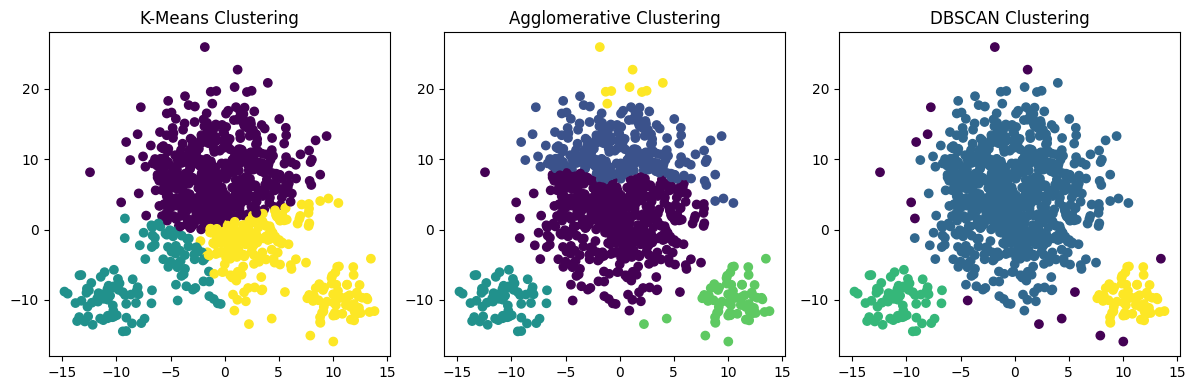

In [17]:
plt.figure(figsize=(12, 4))

# K-Means
plt.subplot(1, 3, 1)
plt.scatter(X[:, 0], X[:, 1], c=labels_kmeans)
plt.title("K-Means Clustering")

# Agglomerative Clustering
plt.subplot(1, 3, 2)
plt.scatter(X[:, 0], X[:, 1], c=labels_agg)
plt.title("Agglomerative Clustering")

# DBSCAN
plt.subplot(1, 3, 3)
plt.scatter(X[:, 0], X[:, 1], c=labels_dbscan)
plt.title("DBSCAN Clustering")

plt.tight_layout()
plt.show()

In [20]:
# Silhouette scores
silhouette_kmeans = silhouette_score(X, labels_kmeans)
silhouette_agg = silhouette_score(X, labels_agg)
silhouette_dbscan = silhouette_score(X[non_noise_indices], labels_dbscan[non_noise_indices])

silhouette_scores["skewed"] = {
    "K-Means": silhouette_kmeans,
    "Agglomerative Clustering": silhouette_agg,
    "DBSCAN": silhouette_dbscan
}

# Intra-cluster distance (sum of squared distances to centroids)
kmeans_intra_distance = kmeans.inertia_
agg_intra_distance = np.sum([np.linalg.norm(X[labels_agg == i] - np.mean(X[labels_agg == i], axis=0)) ** 2 for i in range(3)])
dbscan_intra_distance = np.sum([np.linalg.norm(X[labels_dbscan == i] - np.mean(X[labels_dbscan == i], axis=0)) ** 2 for i in range(np.max(labels_dbscan) + 1)])

# Tabulate results
results = pd.DataFrame({
    "Algorithm": ["K-Means", "Agglomerative Clustering", "DBSCAN"],
    "Silhouette Score": [silhouette_kmeans, silhouette_agg, silhouette_dbscan],
    "Intra-Cluster Distance": [kmeans_intra_distance, agg_intra_distance, dbscan_intra_distance],
    "Noise Points": [0, 0, noise_points]
})

results

,Algorithm,Silhouette Score,Intra-Cluster Distance,Noise Points
0,K-Means,0.429143,31014.871887,0
1,Agglomerative Clustering,0.348568,21640.576044,0
2,DBSCAN,0.498486,38525.676717,15


Analysis:

It appears that DBSCAN is the best method for this dataset. While it has the highest inter-cluster distance, it also has the highest silhouette score, and visually, it is the only method that has been able to separate the clusters well. This is the reason why DBSCAN is the best method for this dataset.

#### dataset: `Subclusters.csv`

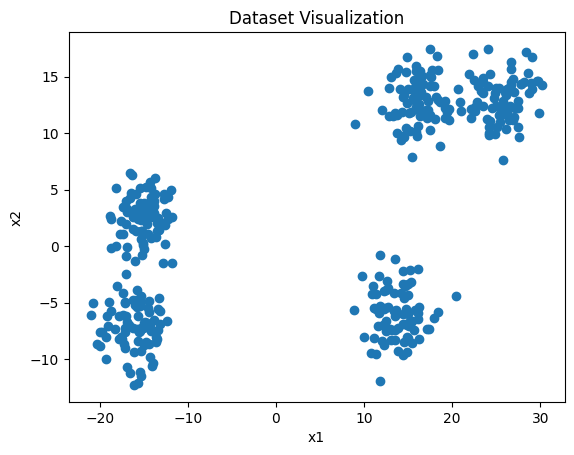

In [ ]:
data = pd.read_csv('./Dataset_a5/Dataset2/Subclusters.csv')

X = data[["x1", "x2"]].values

plt.scatter(X[:, 0], X[:, 1])
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Dataset Visualization")
plt.show()


In [22]:
kmeans = KMeansScratch(k=5)

kmeans.fit(X)
labels_kmeans = kmeans.labels_

In [23]:
linkages = ['ward', 'complete', 'average', 'single']

best_silhouette = -1
best_linkage = None

for linkage in linkages:
    agg_clustering = AgglomerativeClustering(n_clusters=3, linkage=linkage)
    agg_clustering.fit(X)
    labels_agg_tmp = agg_clustering.labels_

    silhouette_tmp = silhouette_score(X, labels_agg_tmp)

    if silhouette_tmp > best_silhouette:
        best_silhouette = silhouette_tmp
        best_linkage = linkage

print(f"Best linkage: {best_linkage}")
# print(f"Best silhouette score: {best_silhouette}")

agg_clustering = AgglomerativeClustering(n_clusters=5, linkage=best_linkage)
agg_clustering.fit(X)
labels_agg = agg_clustering.labels_

Best linkage: ward


In [24]:
# eps_values = [1, 2, 3, 4, 5]
# min_samples_values = [1, 10, 20, 30, 40, 50]

# best_silhouette = -1
# best_eps = None
# best_min_samples = None
# labels_dbscan = None
# noise_points = None

# for eps in eps_values:
#     for min_samples in min_samples_values:
#         dbscan = DBSCAN(eps=eps, min_samples=min_samples)
#         dbscan.fit(X)
#         labels_dbscan_tmp = dbscan.labels_

#         # Ignore noise points for silhouette score
#         non_noise_indices = labels_dbscan_tmp != -1
#         if len(set(labels_dbscan_tmp[non_noise_indices])) > 1:
#             silhouette_tmp = silhouette_score(X[non_noise_indices], labels_dbscan_tmp[non_noise_indices])
#         else:
#             silhouette_tmp = -1  # Assign a low silhouette score if only one cluster is found

#         if silhouette_tmp > best_silhouette:
#             best_silhouette = silhouette_tmp
#             best_eps = eps
#             best_min_samples = min_samples
#             labels_dbscan = labels_dbscan_tmp
#             noise_points = np.sum(labels_dbscan == -1)

# print(f"Best eps: {best_eps}")
# print(f"Best min_samples: {best_min_samples}")
# print(f"Best silhouette score: {best_silhouette}")

dbscan = DBSCAN(eps=5, min_samples=10)
dbscan.fit(X)
labels_dbscan = dbscan.labels_
noise_points = np.sum(labels_dbscan == -1)
non_noise_indices = labels_dbscan != -1

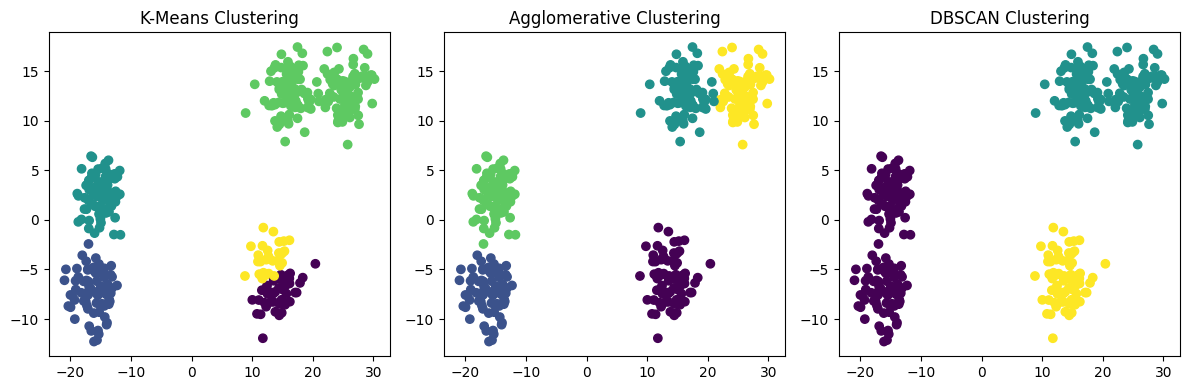

In [25]:
plt.figure(figsize=(12, 4))

# K-Means
plt.subplot(1, 3, 1)
plt.scatter(X[:, 0], X[:, 1], c=labels_kmeans)
plt.title("K-Means Clustering")

# Agglomerative Clustering
plt.subplot(1, 3, 2)
plt.scatter(X[:, 0], X[:, 1], c=labels_agg)
plt.title("Agglomerative Clustering")

# DBSCAN
plt.subplot(1, 3, 3)
plt.scatter(X[:, 0], X[:, 1], c=labels_dbscan)
plt.title("DBSCAN Clustering")

plt.tight_layout()
plt.show()

In [26]:
# Silhouette scores
silhouette_kmeans = silhouette_score(X, labels_kmeans)
silhouette_agg = silhouette_score(X, labels_agg)
silhouette_dbscan = silhouette_score(X[non_noise_indices], labels_dbscan[non_noise_indices])

silhouette_scores["subclusters"] = {
    "K-Means": silhouette_kmeans,
    "Agglomerative Clustering": silhouette_agg,
    "DBSCAN": silhouette_dbscan
}

# Intra-cluster distance (sum of squared distances to centroids)
kmeans_intra_distance = kmeans.inertia_
agg_intra_distance = np.sum([np.linalg.norm(X[labels_agg == i] - np.mean(X[labels_agg == i], axis=0)) ** 2 for i in range(3)])
dbscan_intra_distance = np.sum([np.linalg.norm(X[labels_dbscan == i] - np.mean(X[labels_dbscan == i], axis=0)) ** 2 for i in range(np.max(labels_dbscan) + 1)])

# Tabulate results
results = pd.DataFrame({
    "Algorithm": ["K-Means", "Agglomerative Clustering", "DBSCAN"],
    "Silhouette Score": [silhouette_kmeans, silhouette_agg, silhouette_dbscan],
    "Intra-Cluster Distance": [kmeans_intra_distance, agg_intra_distance, dbscan_intra_distance],
    "Noise Points": [0, 0, noise_points]
})

results

,Algorithm,Silhouette Score,Intra-Cluster Distance,Noise Points
0,K-Means,0.586788,6626.821232,0
1,Agglomerative Clustering,0.668312,2058.387038,0
2,DBSCAN,0.738949,10795.396187,0


Analysis:

In this case, it is hard to say which method is the best. K-means has the lowest silhouette score, an average intra-cluster distance, and visually, it does a good job except for one of the clusters. DBSCAN has the highest silhouette score, but also the highest intra-cluster distance, and visually, while it does separate the clusters well, it seems like it can't capture the subclusters well. Agglomerative clustering has an average silhouette score, and the lowest intra-cluster distance. However, visually, it has separated the clusters well, including the subclusters. This is the reason why Agglomerative clustering is the best method for this dataset.

#### dataset: `wellSeperated.csv`

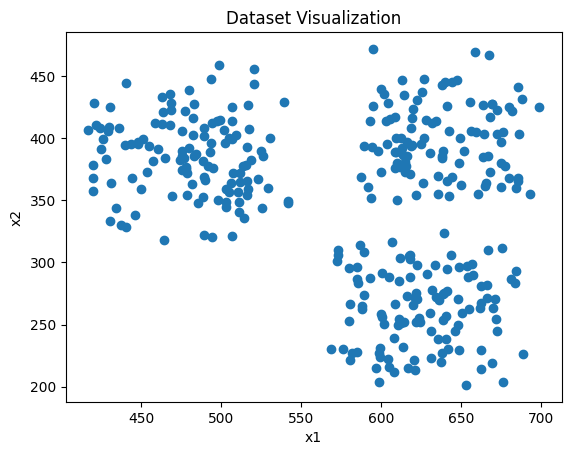

In [27]:
data = pd.read_csv('./Dataset_a5/Dataset2/wellSeperated.csv')

X = data[["x1", "x2"]].values

plt.scatter(X[:, 0], X[:, 1])
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Dataset Visualization")
plt.show()


In [28]:
kmeans = KMeansScratch(k=3)

kmeans.fit(X)
labels_kmeans = kmeans.labels_

In [29]:
linkages = ['ward', 'complete', 'average', 'single']

best_silhouette = -1
best_linkage = None

for linkage in linkages:
    agg_clustering = AgglomerativeClustering(n_clusters=3, linkage=linkage)
    agg_clustering.fit(X)
    labels_agg_tmp = agg_clustering.labels_

    silhouette_tmp = silhouette_score(X, labels_agg_tmp)

    if silhouette_tmp > best_silhouette:
        best_silhouette = silhouette_tmp
        best_linkage = linkage

print(f"Best linkage: {best_linkage}")
# print(f"Best silhouette score: {best_silhouette}")

agg_clustering = AgglomerativeClustering(n_clusters=5, linkage=best_linkage)
agg_clustering.fit(X)
labels_agg = agg_clustering.labels_

Best linkage: ward


In [30]:
# eps_values = [1, 2, 3, 4, 5]
# min_samples_values = [1, 10, 20, 30, 40, 50]

# best_silhouette = -1
# best_eps = None
# best_min_samples = None
# labels_dbscan = None
# noise_points = None

# for eps in eps_values:
#     for min_samples in min_samples_values:
#         dbscan = DBSCAN(eps=eps, min_samples=min_samples)
#         dbscan.fit(X)
#         labels_dbscan_tmp = dbscan.labels_

#         # Ignore noise points for silhouette score
#         non_noise_indices = labels_dbscan_tmp != -1
#         if len(set(labels_dbscan_tmp[non_noise_indices])) > 1:
#             silhouette_tmp = silhouette_score(X[non_noise_indices], labels_dbscan_tmp[non_noise_indices])
#         else:
#             silhouette_tmp = -1  # Assign a low silhouette score if only one cluster is found

#         if silhouette_tmp > best_silhouette:
#             best_silhouette = silhouette_tmp
#             best_eps = eps
#             best_min_samples = min_samples
#             labels_dbscan = labels_dbscan_tmp
#             noise_points = np.sum(labels_dbscan == -1)

# if best_eps is not None and best_min_samples is not None:
#     print(f"Best eps: {best_eps}")
#     print(f"Best min_samples: {best_min_samples}")
#     print(f"Best silhouette score: {best_silhouette}")

#     # Use best parameters for DBSCAN
#     dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples)
#     dbscan.fit(X)
#     labels_dbscan = dbscan.labels_
#     noise_points = np.sum(labels_dbscan == -1)
# else:
#     print("No valid eps and min_samples combination found.")

dbscan = DBSCAN(eps=30, min_samples=10)
dbscan.fit(X)
labels_dbscan = dbscan.labels_
noise_points = np.sum(labels_dbscan == -1)

non_noise_indices = labels_dbscan != -1

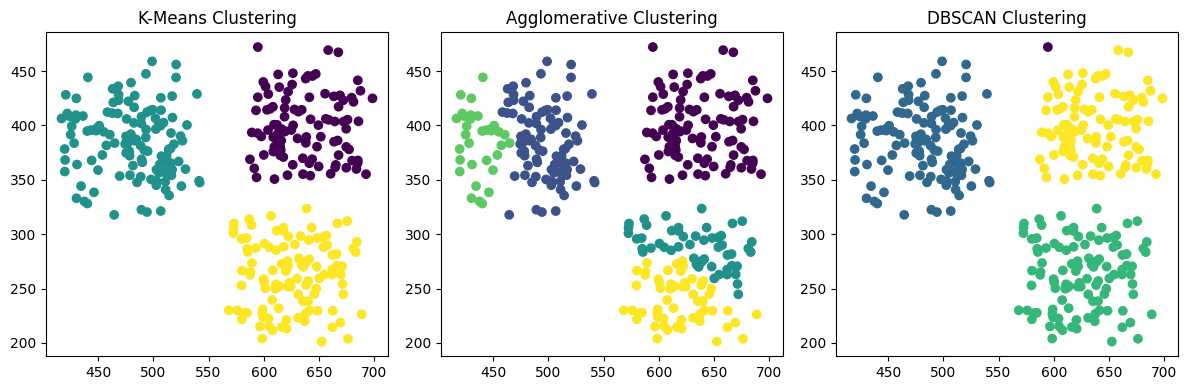

In [31]:
plt.figure(figsize=(12, 4))

# K-Means
plt.subplot(1, 3, 1)
plt.scatter(X[:, 0], X[:, 1], c=labels_kmeans)
plt.title("K-Means Clustering")

# Agglomerative Clustering
plt.subplot(1, 3, 2)
plt.scatter(X[:, 0], X[:, 1], c=labels_agg)
plt.title("Agglomerative Clustering")

# DBSCAN
plt.subplot(1, 3, 3)
plt.scatter(X[:, 0], X[:, 1], c=labels_dbscan)
plt.title("DBSCAN Clustering")

plt.tight_layout()
plt.show()

In [32]:
# Silhouette scores
silhouette_kmeans = silhouette_score(X, labels_kmeans)
silhouette_agg = silhouette_score(X, labels_agg)
silhouette_dbscan = silhouette_score(X[non_noise_indices], labels_dbscan[non_noise_indices])

silhouette_scores["wellSeparated"] = {
    "K-Means": silhouette_kmeans,
    "Agglomerative Clustering": silhouette_agg,
    "DBSCAN": silhouette_dbscan
}

# Intra-cluster distance (sum of squared distances to centroids)
kmeans_intra_distance = kmeans.inertia_
agg_intra_distance = np.sum([np.linalg.norm(X[labels_agg == i] - np.mean(X[labels_agg == i], axis=0)) ** 2 for i in range(3)])
dbscan_intra_distance = np.sum([np.linalg.norm(X[labels_dbscan == i] - np.mean(X[labels_dbscan == i], axis=0)) ** 2 for i in range(np.max(labels_dbscan) + 1)])

# Tabulate results
results = pd.DataFrame({
    "Algorithm": ["K-Means", "Agglomerative Clustering", "DBSCAN"],
    "Silhouette Score": [silhouette_kmeans, silhouette_agg, silhouette_dbscan],
    "Intra-Cluster Distance": [kmeans_intra_distance, agg_intra_distance, dbscan_intra_distance],
    "Noise Points": [0, 0, noise_points]
})

results

,Algorithm,Silhouette Score,Intra-Cluster Distance,Noise Points
0,K-Means,0.613946,629926.614046,0
1,Agglomerative Clustering,0.396587,376185.033656,0
2,DBSCAN,0.614976,622758.765930,1


Analysis:

Both K-means and DBSCAN do a really good job in this case while Agglomerative clustering is not able to separate the clusters that well and has the lowest silhouette score, though it has the lowest intra-cluster distance, but that is possibly because it has overclustered the data. Both K-means and DBSCAN have almost equally high silhouette scores and also almost equal intra-cluster distances. However, DBSCAN does validly identify one noise point, which K-means doesn't. This is the reason why DBSCAN is the best method for this dataset.

#### Overall

Silhouette scores

In [ ]:
silhouette_scores_df = pd.DataFrame(silhouette_scores)
silhouette_scores_df

,compact,skewed,subclusters,wellSeparated
K-Means,0.91178,0.408248,0.668823,0.613946
Agglomerative Clustering,0.91178,0.348568,0.668312,0.396587
DBSCAN,0.91178,0.498486,0.738949,0.614976
